# Grid Square Area Chart

This notebook demonstrates a grid-based visualization where each cell contains a square whose area represents a percentage value. The chart is similar to the McKinsey-style grid charts showing survey responses across age groups.


In [35]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import textwrap

import dartwork_mpl as dm

dm.style.use_preset("scientific")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def plot_grid_square_area(
    data,
    row_labels,
    col_labels,
    highlight_cols=None,
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    row_label_width=None,
    row_label_wrap_length=15,
    row_label_margin=0.1,
    square_align="center",
    colors=None,
    title=None,
    title_fontsize=None,
    label_fontsize=None,
    value_fontsize=None,
    figsize=None,
    dpi=300,
):
    """
    Create a grid-based chart where each cell contains a square whose area represents a percentage value.

    Parameters
    ----------
    data : array-like, shape (n_rows, n_cols)
        2D array of percentage values (0-100) for each cell.
    row_labels : list of str
        Labels for each row (left side).
    col_labels : list of str
        Labels for each column (bottom).
    highlight_cols : list of int, optional
        Column indices to highlight with different color. Default is None.
    cell_size : float, optional
        Base size of each cell in figure units. Default is 0.4.
    cell_spacing : float, optional
        Spacing between cells as fraction of cell_size. Default is 0.15.
    margin : float, optional
        Margin around the entire grid as fraction of cell_size. Default is 0.1.
    row_label_width : float or None, optional
        Width allocated for row labels in units of cell_size.
        If None, automatically calculated based on row_label_wrap_length.
    row_label_wrap_length : int, optional
        Maximum number of characters per line for row labels before wrapping.
        Default is 15 characters.
    row_label_margin : float, optional
        Horizontal spacing between row labels and grid in units of cell_size.
        Default is 0.1.
    square_align : str, optional
        Alignment of the inner square within each cell.
        Options: 'center', 'top-left', 'bottom-left', 'bottom-right', 'top-right'.
        Default is 'center'.
    colors : dict, optional
        Dictionary with keys 'default' and 'highlight' specifying colors.
        Default uses 'dm.blue5' and 'dm.blue3'.
    title : str, optional
        Title for the chart. Default is None.
    title_fontsize : float or None, optional
        Font size for title. If None, uses dm.fs(1).
    label_fontsize : float or None, optional
        Font size for row/column labels. If None, uses dm.fs(0).
    value_fontsize : float or None, optional
        Font size for percentage values. If None, uses dm.fs(-1).
    figsize : tuple of float or None, optional
        Figure size in inches (width, height). If None, calculated automatically.
    dpi : int, optional
        Resolution of the figure in dots per inch. Default is 300.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure object.
    ax : matplotlib.axes.Axes
        The axes containing the plot.
    """
    # Convert data to numpy array for easier manipulation
    data = np.array(data)
    n_rows, n_cols = data.shape

    # Validate input dimensions
    if len(row_labels) != n_rows:
        raise ValueError(
            f"Number of row_labels ({len(row_labels)}) must match number of rows ({n_rows})"
        )
    if len(col_labels) != n_cols:
        raise ValueError(
            f"Number of col_labels ({len(col_labels)}) must match number of columns ({n_cols})"
        )

    # Validate alignment option
    valid_aligns = ["center", "top-left", "bottom-left", "bottom-right", "top-right"]
    if square_align not in valid_aligns:
        raise ValueError(
            f"square_align must be one of {valid_aligns}, got '{square_align}'"
        )

    # Set default colors if not provided
    if colors is None:
        colors = {
            "default": "dm.blue5",  # Default square color
            "highlight": "dm.blue3",  # Highlighted column color
        }

    # Set default font sizes using dartwork_mpl sizing
    if title_fontsize is None:
        title_fontsize = dm.fs(1)  # Larger font for title
    if label_fontsize is None:
        label_fontsize = dm.fs(0)  # Standard font for labels
    if value_fontsize is None:
        value_fontsize = dm.fs(-1)  # Smaller font for values

    # Handle highlight columns - convert to set for efficient lookup
    if highlight_cols is None:
        highlight_cols = []
    highlight_cols = set(highlight_cols)

    # Calculate grid dimensions
    spacing = cell_spacing * cell_size

    # Estimate width needed for row labels
    if row_label_width is None:
        # Auto-calculate based on wrap length plus margin
        # Each character is approximately 0.015 * cell_size wide
        row_label_width = (row_label_wrap_length * 0.015 + row_label_margin) * cell_size
    else:
        # Use provided width (convert to same units as cell_size)
        row_label_width = row_label_width * cell_size

    # Space needed for column labels above grid
    col_label_height = 0.15

    # Space needed for title above column labels
    title_height = 0.2 if title else 0.05

    # Calculate total grid dimensions
    grid_width = n_cols * cell_size + (n_cols - 1) * spacing
    grid_height = n_rows * cell_size + (n_rows - 1) * spacing

    # Calculate total figure dimensions
    total_width = grid_width + 2 * margin * cell_size + row_label_width
    total_height = (
        grid_height + 2 * margin * cell_size + col_label_height + title_height
    )

    # Auto-calculate figure size if not provided
    if figsize is None:
        aspect_ratio = total_width / total_height
        base_size = 14  # cm
        if aspect_ratio > 1:
            fig_width = base_size * aspect_ratio
            fig_height = base_size
        else:
            fig_width = base_size
            fig_height = base_size / aspect_ratio
        figsize = (dm.cm2in(fig_width), dm.cm2in(fig_height))

    # Create figure and axis
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111)

    # Define grid origin (bottom-left corner)
    grid_x0 = margin * cell_size + row_label_width
    grid_y0 = margin * cell_size

    # Draw all cells and squares
    for i in range(n_rows):
        for j in range(n_cols):
            # Calculate cell position (bottom-left corner)
            # Note: rows are drawn from top to bottom
            cell_x = grid_x0 + j * (cell_size + spacing)
            cell_y = grid_y0 + (n_rows - 1 - i) * (cell_size + spacing)

            # Determine color based on highlight status
            is_highlight = j in highlight_cols
            cell_color = colors["highlight"] if is_highlight else colors["default"]

            # Draw outer square (represents 100% reference)
            outer_square = Rectangle(
                (cell_x, cell_y),
                cell_size,
                cell_size,
                facecolor="none",
                edgecolor="dm.gray8",
                linewidth=0.5,
                zorder=1,
            )
            ax.add_patch(outer_square)

            # Calculate inner square size based on percentage
            # Area is proportional to percentage value
            percentage = data[i, j]
            square_side = np.sqrt(percentage / 100.0) * cell_size

            # Calculate position based on alignment option
            if square_align == "center":
                # Center the square in the cell
                square_x = cell_x + (cell_size - square_side) / 2
                square_y = cell_y + (cell_size - square_side) / 2
            elif square_align == "bottom-left":
                # Align to bottom-left corner
                square_x = cell_x
                square_y = cell_y
            elif square_align == "bottom-right":
                # Align to bottom-right corner
                square_x = cell_x + (cell_size - square_side)
                square_y = cell_y
            elif square_align == "top-left":
                # Align to top-left corner
                square_x = cell_x
                square_y = cell_y + (cell_size - square_side)
            elif square_align == "top-right":
                # Align to top-right corner
                square_x = cell_x + (cell_size - square_side)
                square_y = cell_y + (cell_size - square_side)

            # Draw inner square (proportional to percentage)
            inner_square = Rectangle(
                (square_x, square_y),
                square_side,
                square_side,
                facecolor=cell_color,
                edgecolor="white",
                linewidth=0.5,
                zorder=2,
            )
            ax.add_patch(inner_square)

            # Add percentage value text (always centered in cell)
            ax.text(
                cell_x + cell_size / 2,
                cell_y + cell_size / 2,
                f"{int(percentage)}%",
                ha="center",
                va="center",
                fontsize=value_fontsize,
                color="dm.gray9",
                weight=dm.fw(0),
                zorder=3,
            )

    # Add row labels (left side) with text wrapping
    for i in range(n_rows):
        cell_y = grid_y0 + (n_rows - 1 - i) * (cell_size + spacing)
        label_y = cell_y + cell_size / 2

        # Wrap text to specified length
        wrapped_text = textwrap.fill(row_labels[i], width=row_label_wrap_length)

        # Draw wrapped text
        ax.text(
            grid_x0 - row_label_margin * cell_size,
            label_y,
            wrapped_text,
            ha="right",
            va="center",
            fontsize=label_fontsize,
            weight=dm.fw(0),
            wrap=False,  # Already wrapped manually
        )

    # Add column labels (top)
    col_label_y = grid_y0 + grid_height + 0.05 * cell_size
    for j in range(n_cols):
        cell_x = grid_x0 + j * (cell_size + spacing)
        label_x = cell_x + cell_size / 2
        ax.text(
            label_x,
            col_label_y,
            col_labels[j],
            ha="center",
            va="bottom",
            fontsize=label_fontsize,
            weight=dm.fw(0),
        )

    # Add title if provided
    if title:
        title_y = col_label_y + col_label_height + title_height
        ax.text(
            grid_x0 + grid_width / 2,
            title_y,
            title,
            ha="center",
            va="bottom",
            fontsize=title_fontsize,
            weight=dm.fw(1),
        )

    # Set axis limits and turn off axis
    ax.set_xlim(0, total_width)
    ax.set_ylim(0, total_height)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    return fig, ax

## Example: US Employee Sentiment on Gen AI by Age Group

This example recreates the chart from the image showing US employee sentiment on generative AI across different age groups.


In [37]:
# Data: Product satisfaction survey by customer segment
# Each row represents a satisfaction metric, each column a customer segment

row_labels = [
    "Would recommend to friends",
    "Satisfied with product quality",
    "Values innovation and features",
    "Likely to purchase again",
]

col_labels = ["Students", "Professionals", "Small Business", "Enterprise", "Government"]

# Data matrix: satisfaction percentages
data = np.array(
    [
        [85, 78, 92, 88, 76],  # Would recommend
        [90, 95, 89, 94, 91],  # Satisfied with quality
        [82, 88, 75, 86, 70],  # Values innovation
        [78, 85, 91, 87, 83],  # Likely to purchase again
    ]
)

# Highlight the Small Business segment (column index 2)
highlight_cols = [2]

# Use green color scheme
custom_colors = {"default": "dm.green5", "highlight": "dm.green3"}

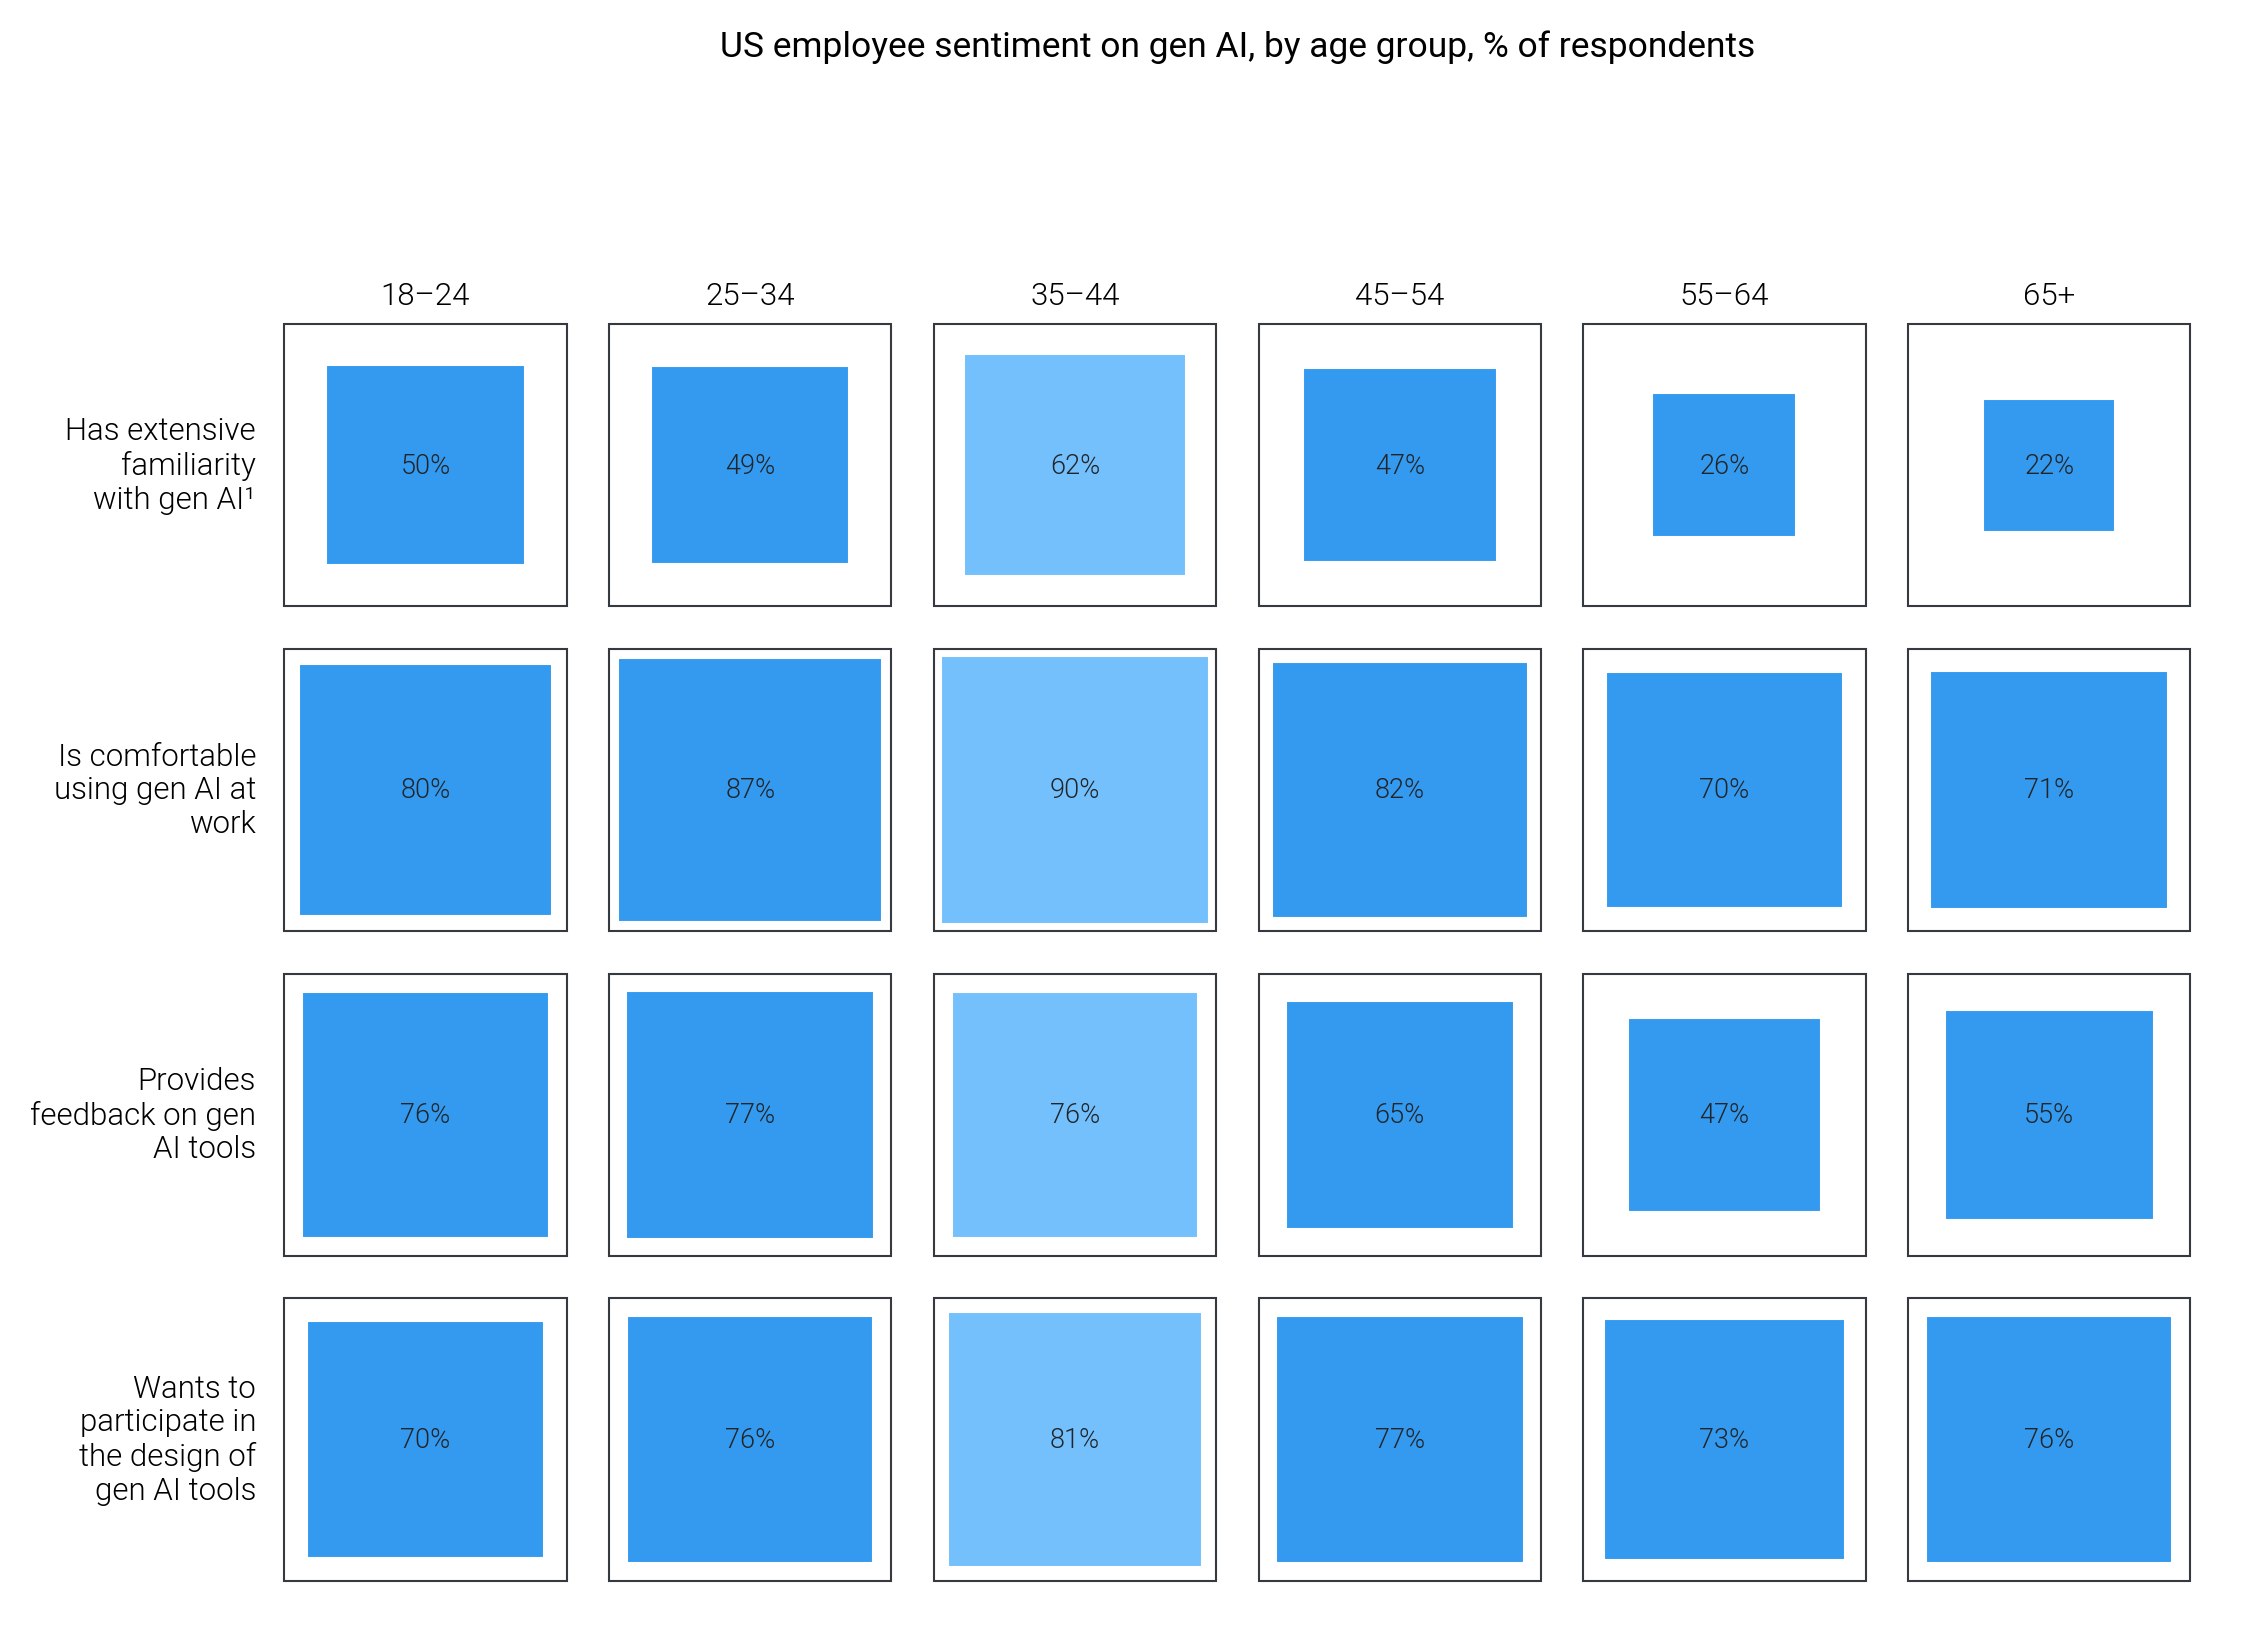

In [38]:
# Create the plot
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    colors={"default": "dm.blue5", "highlight": "dm.blue3"},
    title="US employee sentiment on gen AI, by age group, % of respondents",
)

dm.simple_layout(fig)
plt.show()

## Alignment Options Demo\n\nThe `square_align` parameter allows you to control how squares are positioned within each cell. Below are examples of different alignment options.

In [ ]:
# Example 1: Center alignment (default)\nfig, ax = plot_grid_square_area(\n    data=data[:2, :3],  # Subset for clarity\n    row_labels=row_labels[:2],\n    col_labels=col_labels[:3],\n    square_align='center',\n    colors=custom_colors,\n    title='Center Alignment',\n    highlight_cols=[1]\n)\nplt.show()

In [ ]:
# Example 2: Bottom-left alignment\nfig, ax = plot_grid_square_area(\n    data=data[:2, :3],\n    row_labels=row_labels[:2],\n    col_labels=col_labels[:3],\n    square_align='bottom-left',\n    colors=custom_colors,\n    title='Bottom-Left Alignment',\n    highlight_cols=[1]\n)\nplt.show()

In [ ]:
# Example 3: Top-right alignment\nfig, ax = plot_grid_square_area(\n    data=data[:2, :3],\n    row_labels=row_labels[:2],\n    col_labels=col_labels[:3],\n    square_align='top-right',\n    colors=custom_colors,\n    title='Top-Right Alignment',\n    highlight_cols=[1]\n)\nplt.show()

## Complete Example\n\nFull chart demonstrating all customization options.

In [ ]:
# Complete example with all data\nfig, ax = plot_grid_square_area(\n    data=data,\n    row_labels=row_labels,\n    col_labels=col_labels,\n    highlight_cols=highlight_cols,\n    square_align='center',\n    colors=custom_colors,\n    title='Product Satisfaction by Customer Segment',\n    row_label_wrap_length=20,  # Longer wrap length\n    row_label_margin=0.15      # More margin\n)\nplt.show()

## Customization Examples

The function provides many parameters to customize the layout and appearance. Here are some examples:


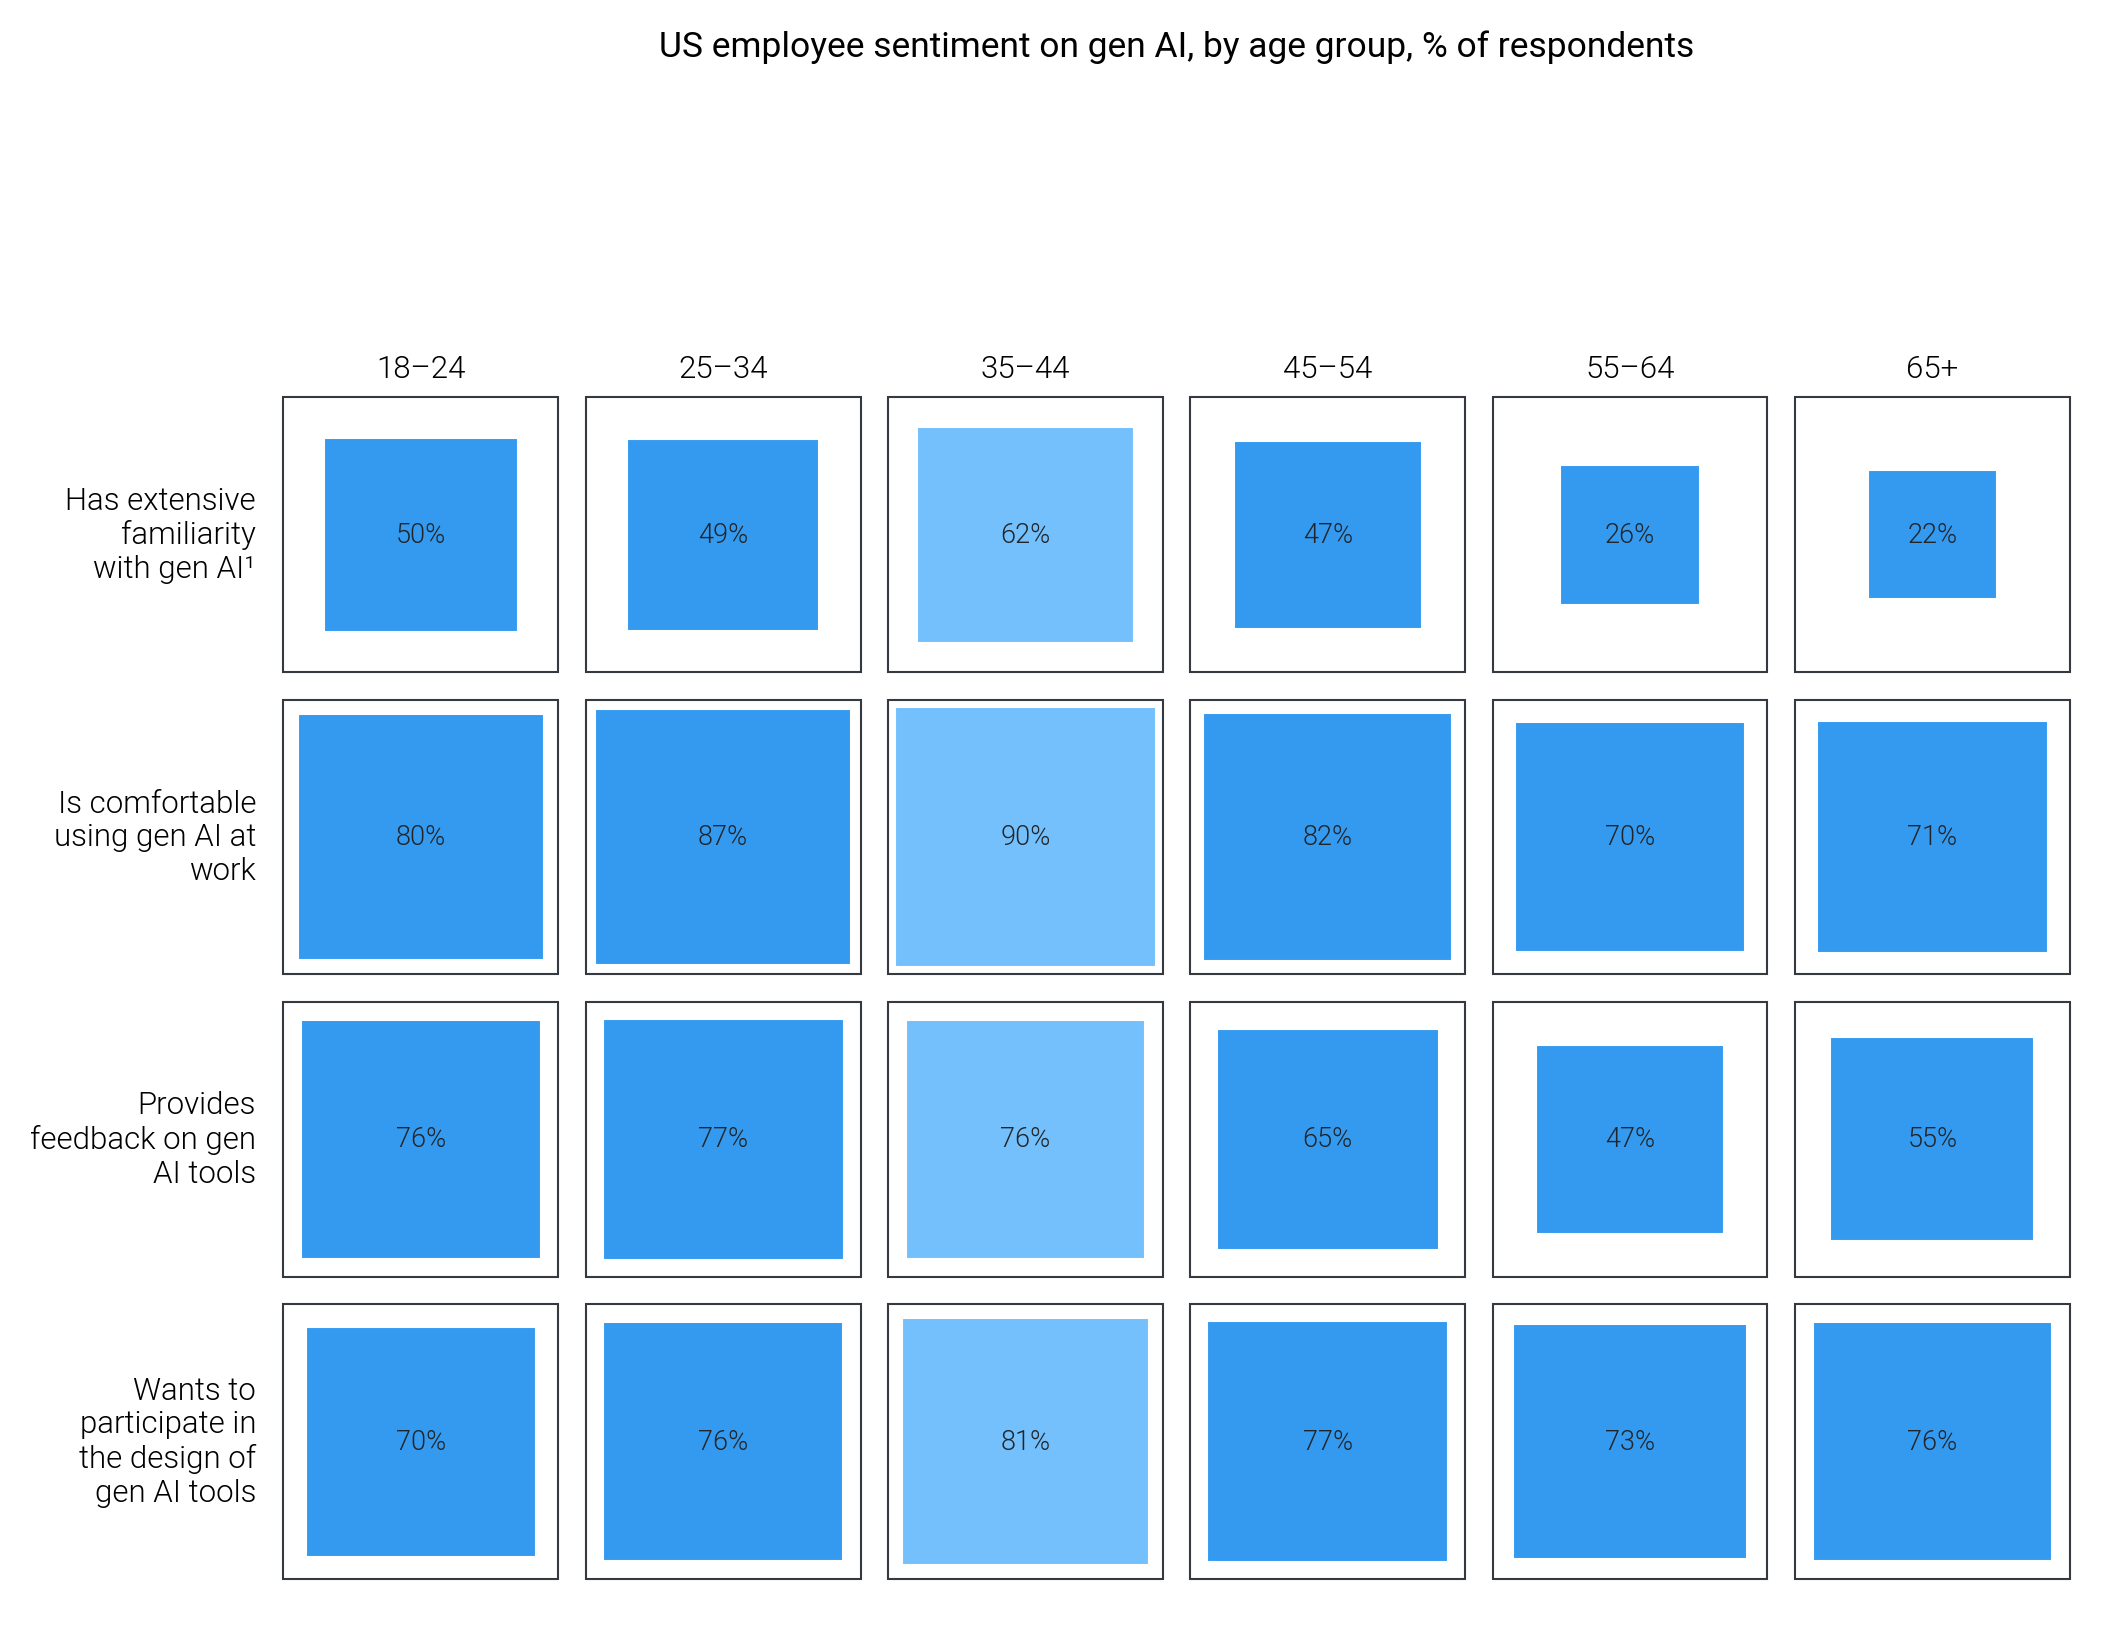

In [39]:
# Example 1: Tighter spacing with smaller cells
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.3,  # Smaller cells
    cell_spacing=0.1,  # Tighter spacing
    margin=0.08,  # Smaller margins
    colors={"default": "dm.blue5", "highlight": "dm.blue3"},
    title="US employee sentiment on gen AI, by age group, % of respondents",
)

dm.simple_layout(fig)
plt.show()

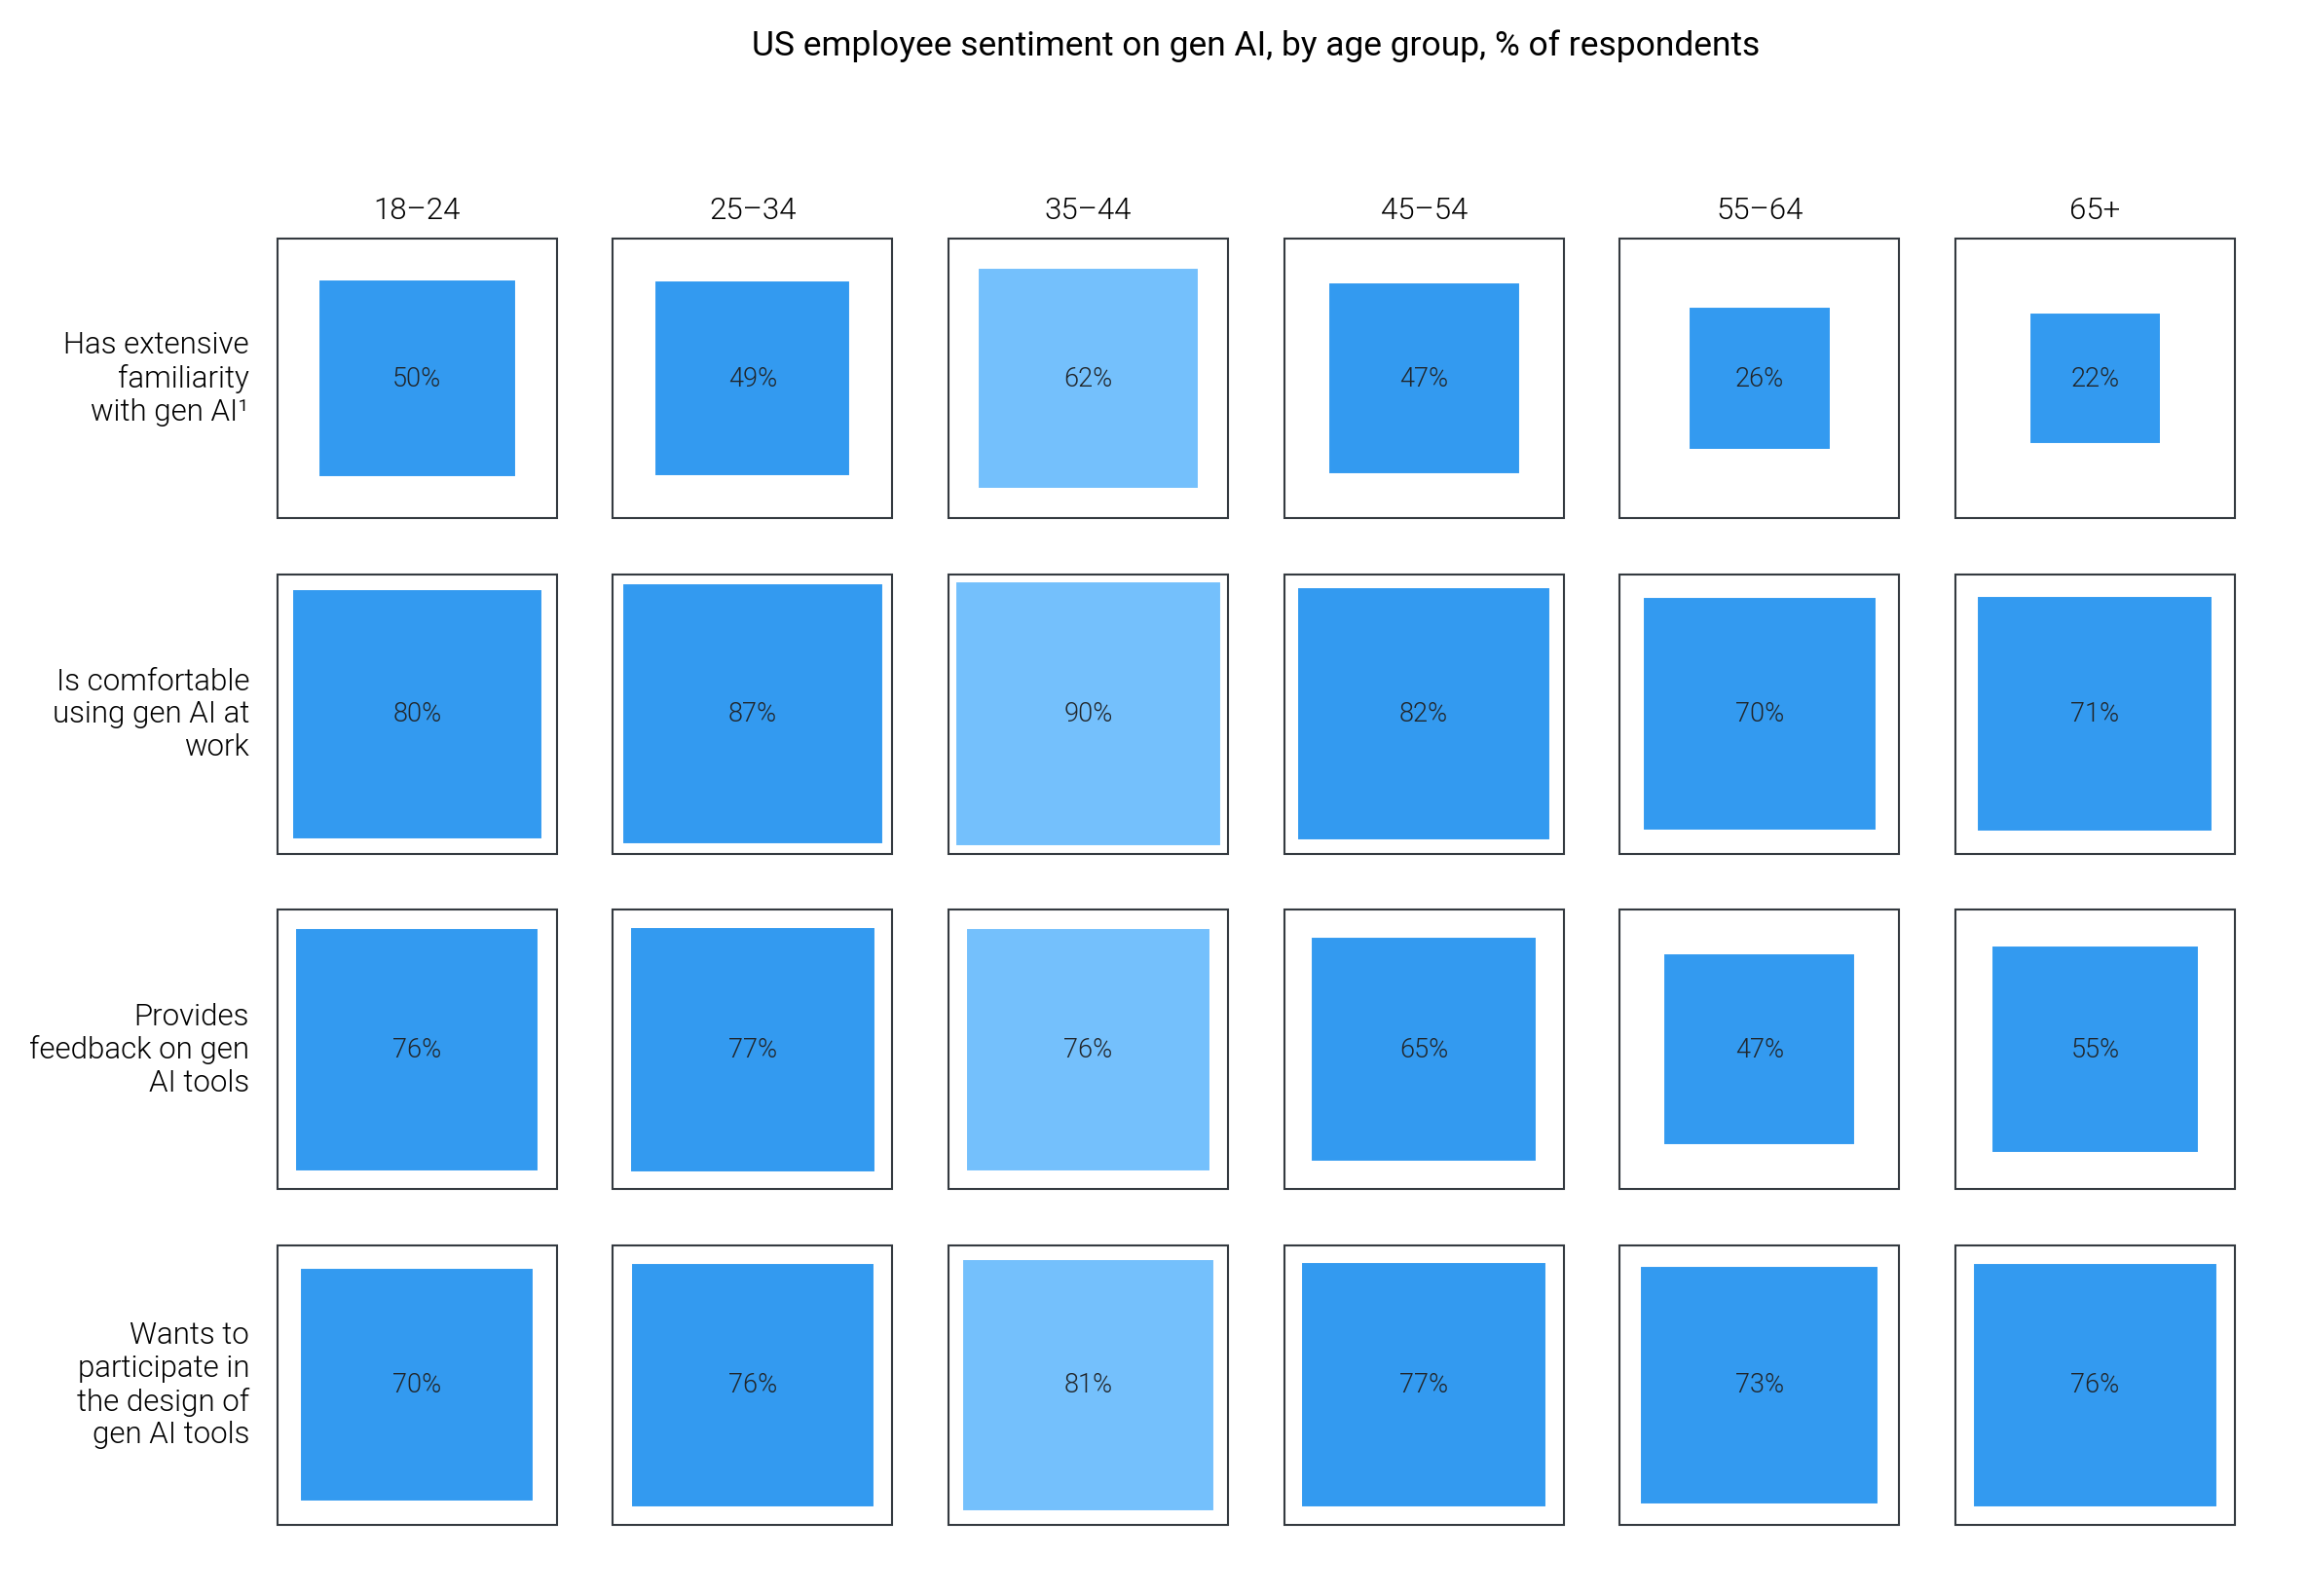

In [40]:
# Example 2: Wider spacing with larger cells
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.6,  # Larger cells
    cell_spacing=0.2,  # Wider spacing
    margin=0.15,  # Larger margins
    colors={"default": "dm.blue5", "highlight": "dm.blue3"},
    title="US employee sentiment on gen AI, by age group, % of respondents",
)

dm.simple_layout(fig)
plt.show()

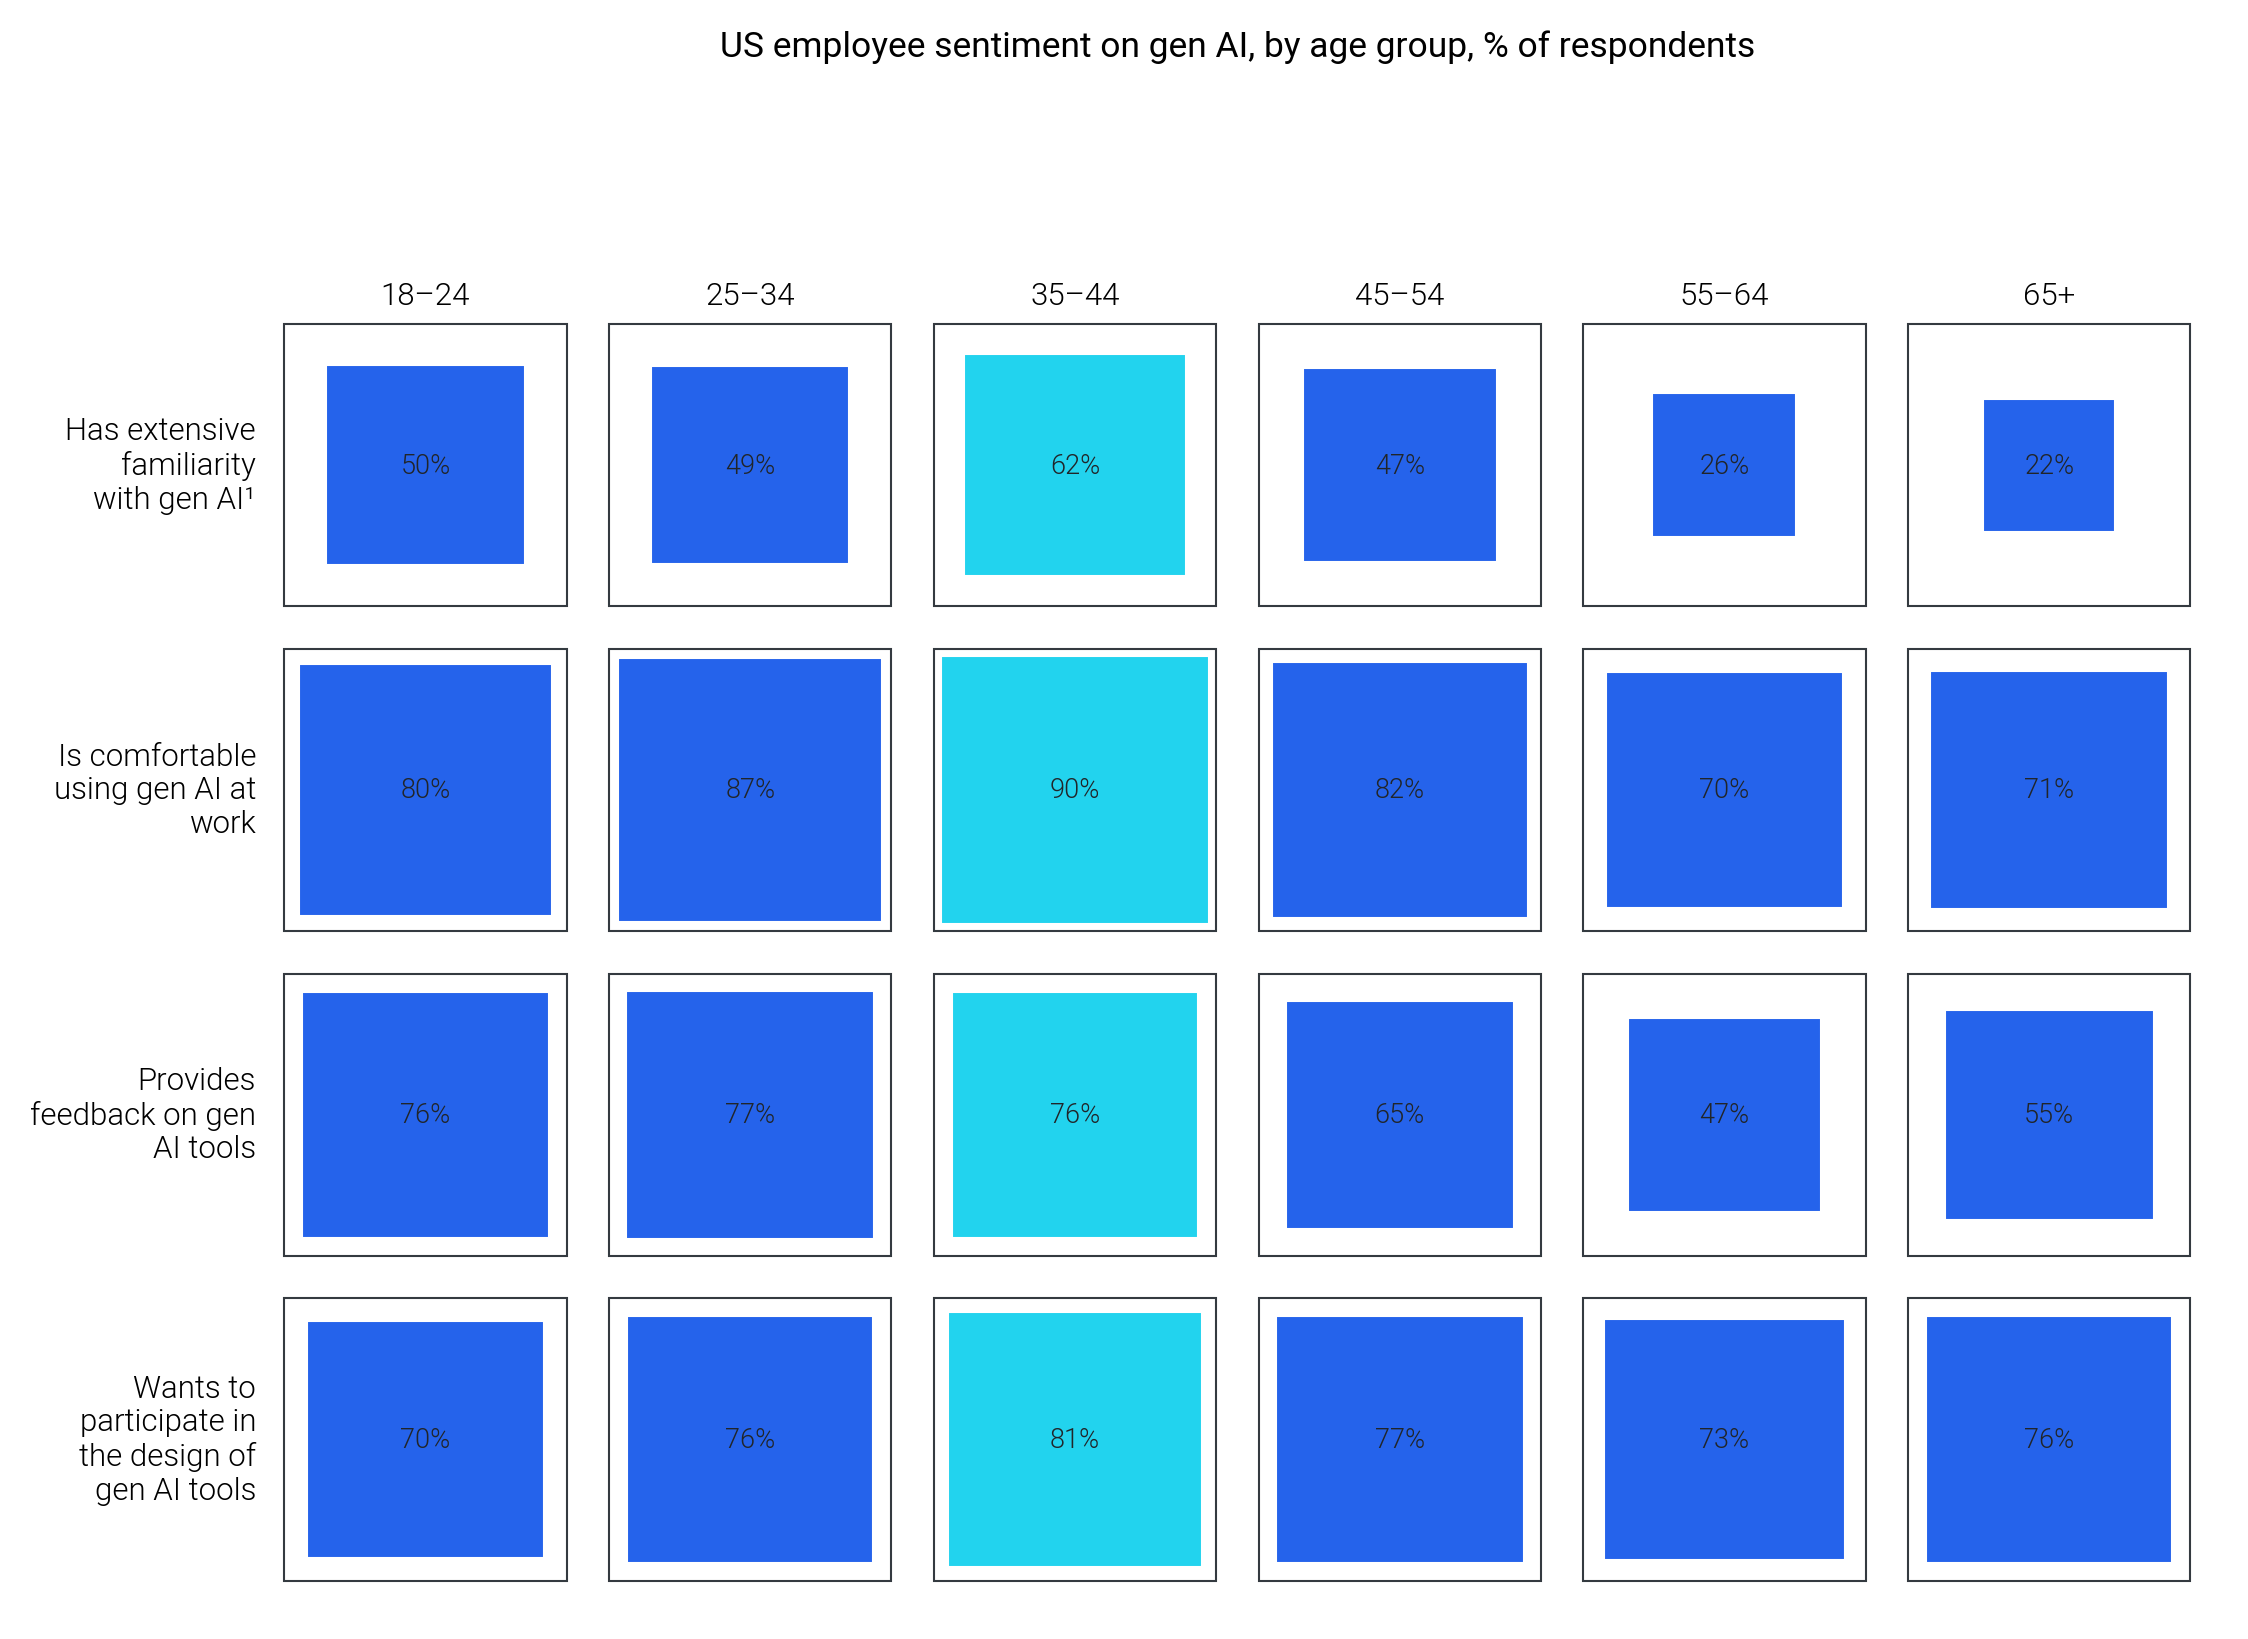

In [41]:
# Example 3: Different color scheme
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    colors={
        "default": "tw.blue:600",
        "highlight": "tw.cyan:400",  # Lighter color for highlight
    },
    title="US employee sentiment on gen AI, by age group, % of respondents",
)

dm.simple_layout(fig)
plt.show()

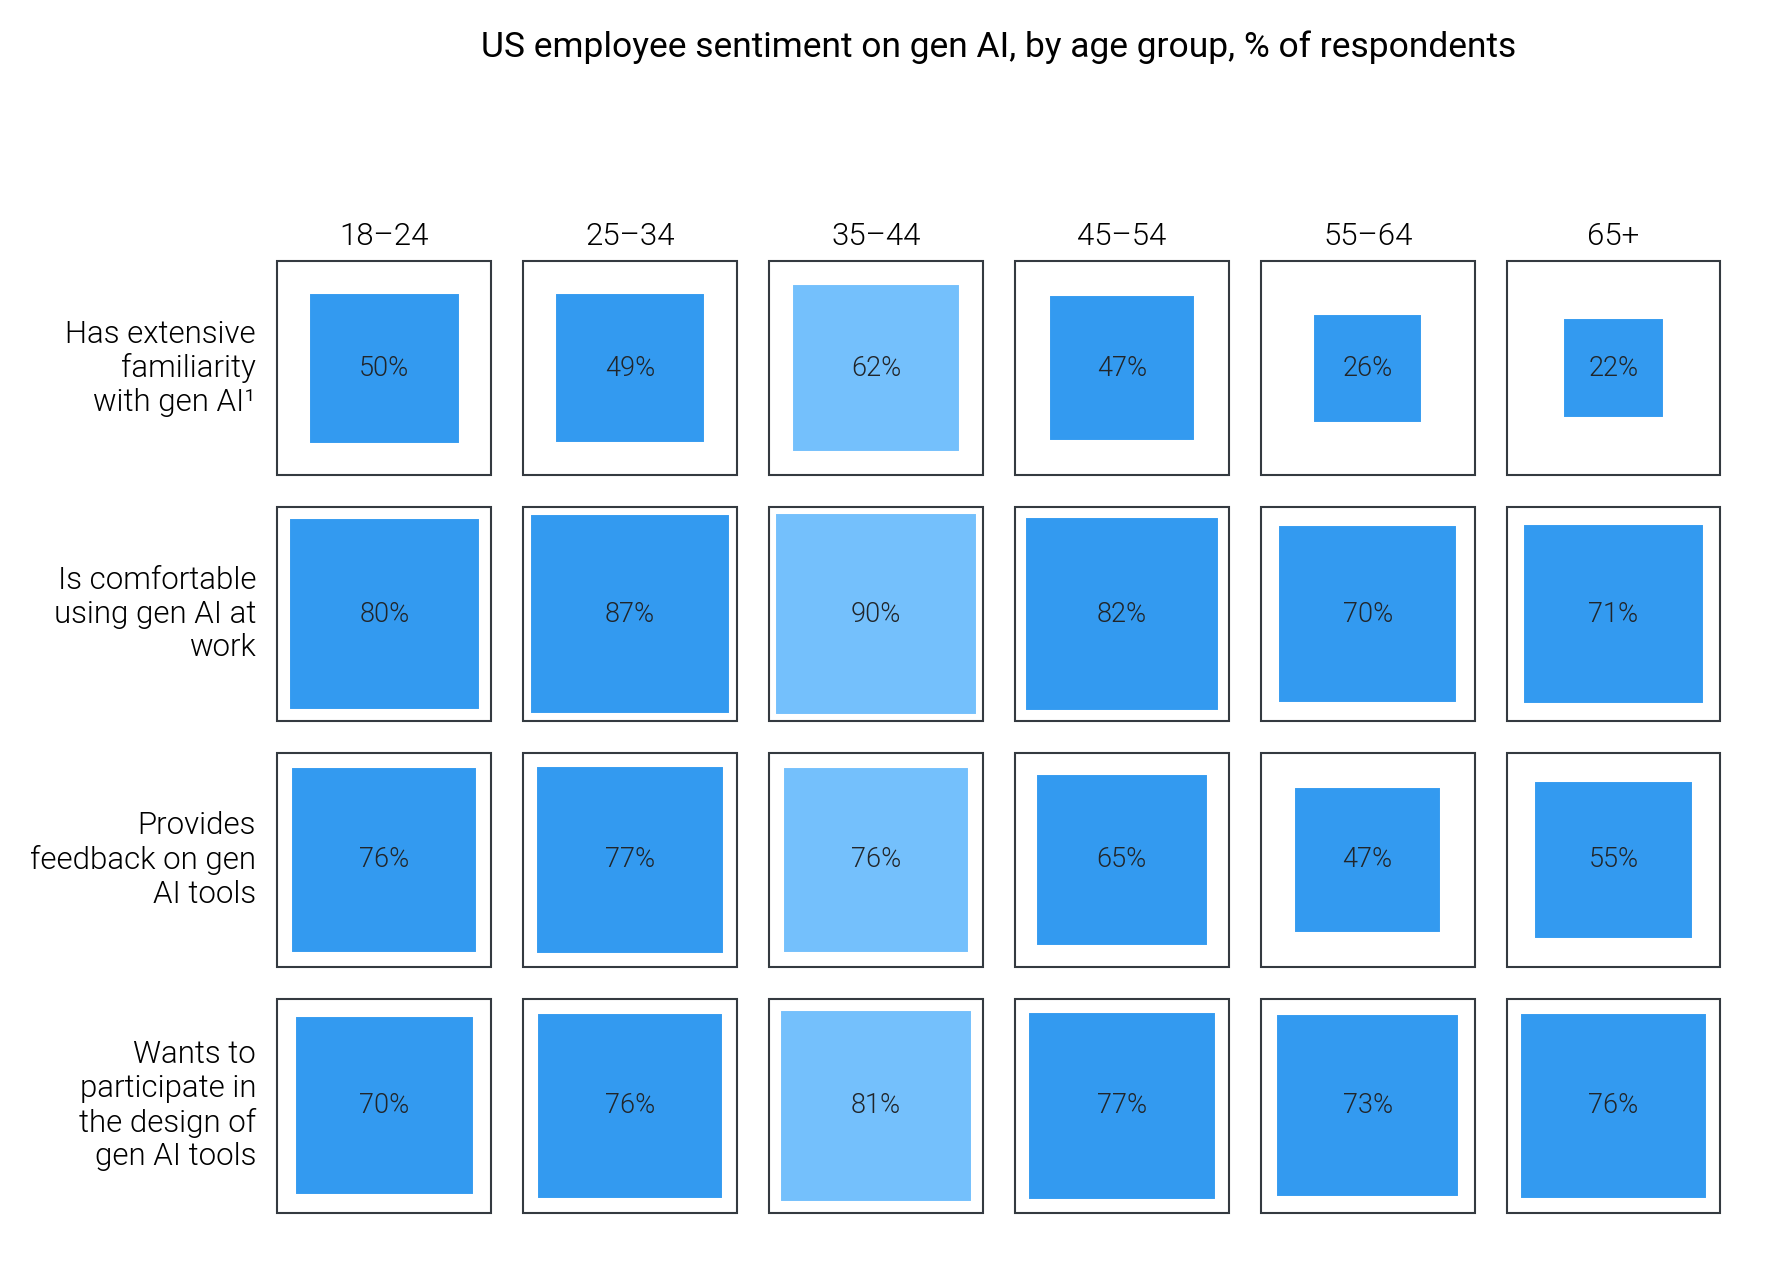

In [42]:
# Example 4: Custom figure size
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=highlight_cols,
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    figsize=(dm.cm2in(18), dm.cm2in(10)),  # Custom figure size
    colors={"default": "dm.blue5", "highlight": "dm.blue3"},
    title="US employee sentiment on gen AI, by age group, % of respondents",
)

dm.simple_layout(fig)
plt.show()

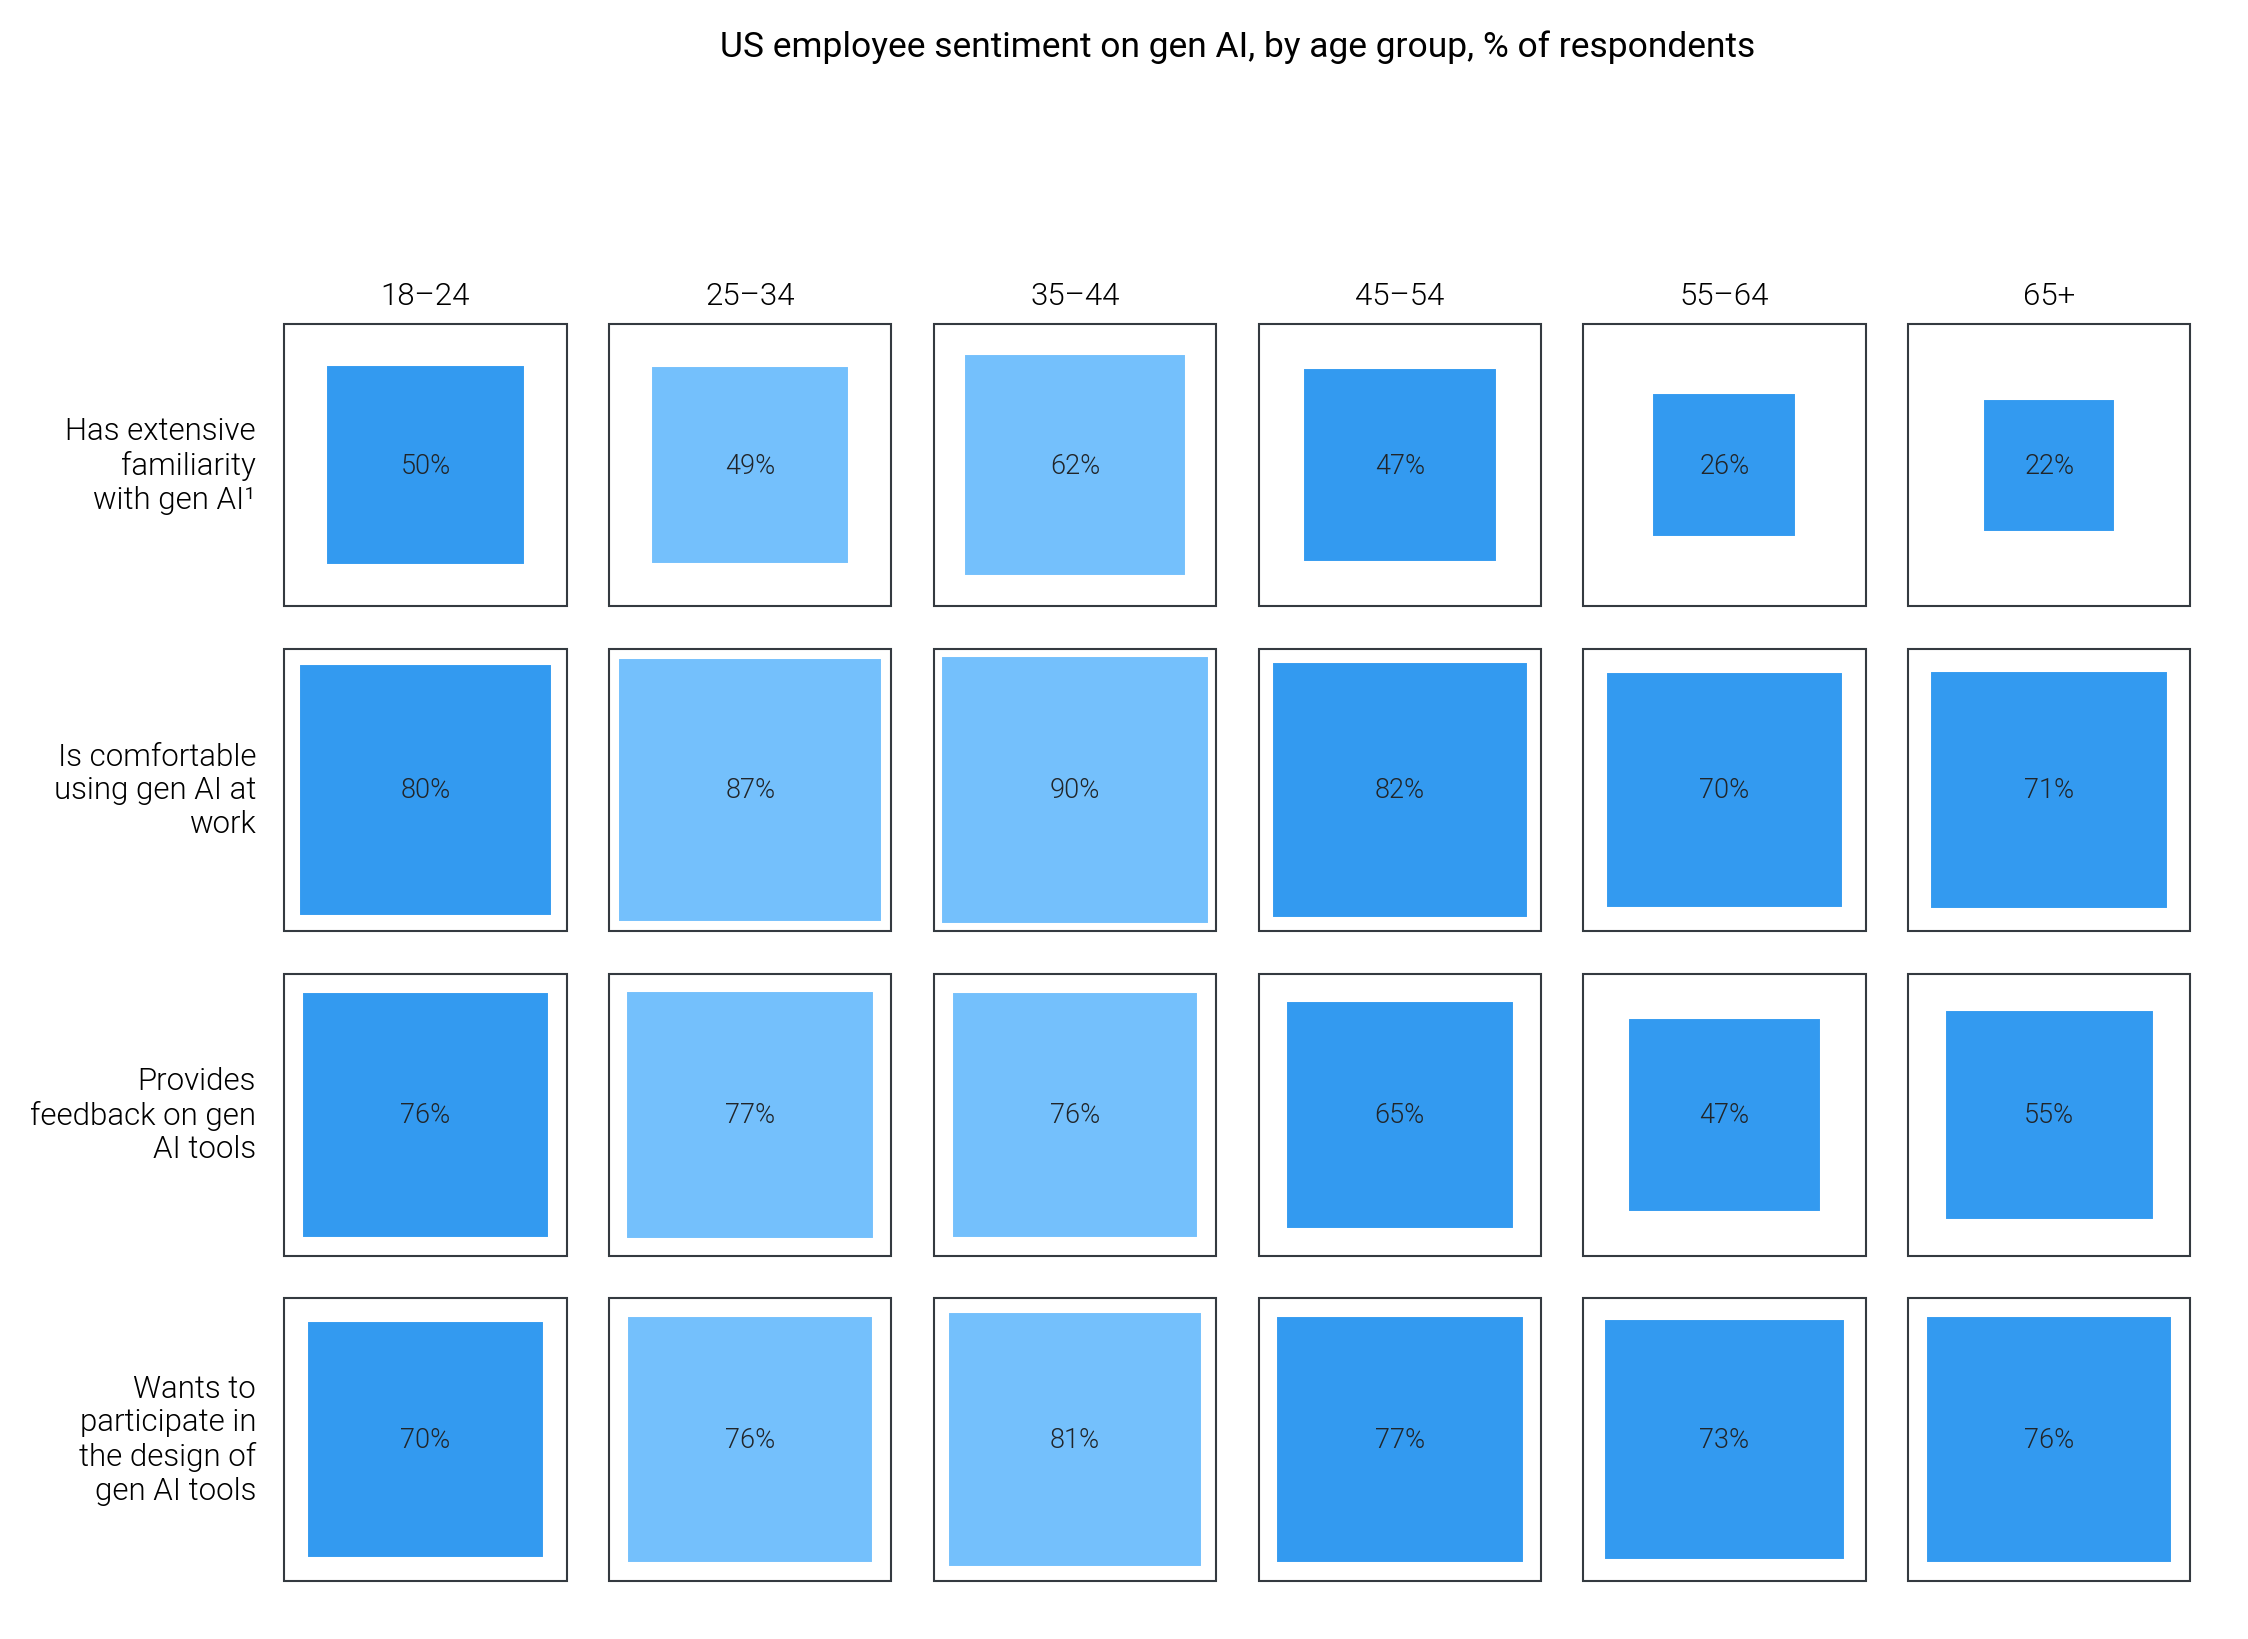

In [43]:
# Example 5: Multiple highlighted columns
fig, ax = plot_grid_square_area(
    data=data,
    row_labels=row_labels,
    col_labels=col_labels,
    highlight_cols=[1, 2],  # Highlight both 25-34 and 35-44
    cell_size=0.4,
    cell_spacing=0.15,
    margin=0.1,
    colors={"default": "dm.blue5", "highlight": "dm.blue3"},
    title="US employee sentiment on gen AI, by age group, % of respondents",
)

dm.simple_layout(fig)
plt.show()

## Parameter Reference

Key parameters for layout customization:

- **`cell_size`**: Base size of each cell (default: 1.0). Increase for larger cells.
- **`cell_spacing`**: Spacing between cells as fraction of cell_size (default: 0.15). Increase for more space between cells.
- **`margin`**: Margin around the entire grid as fraction of cell_size (default: 0.1). Increase for more white space.
- **`figsize`**: Tuple of (width, height) in inches. If None, calculated automatically.
- **`colors`**: Dictionary with 'default' and 'highlight' keys for color specifications.
- **`highlight_cols`**: List of column indices to highlight (0-indexed).
